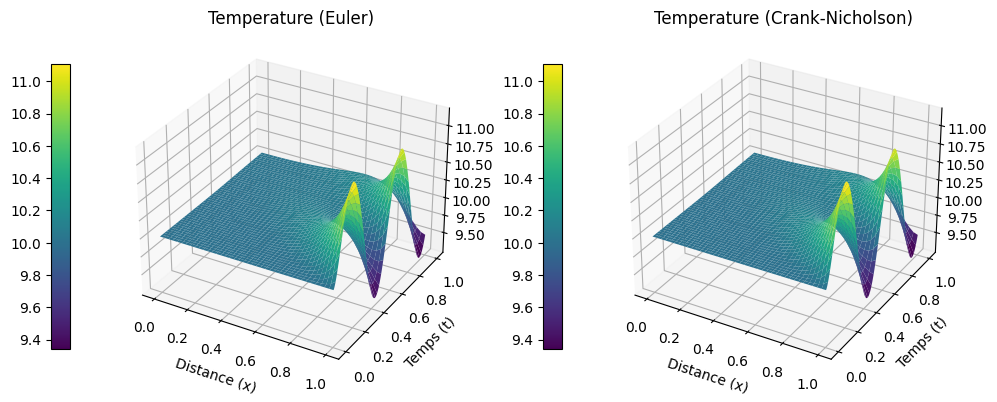

True


In [ ]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Problème direct

# Paramètres
n = 40  # Nombre de noeuds
p = 1000  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité


def Resolution(n, p, L, T, T0, alpha, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature q(t)
    def q_func(t):
        return np.sin(4 * np.pi * t / T)

    # Résolution temporelle
    for i in range(1, p):
      if algo == 'Euler':
        U[:, i] = U[:, i-1] - dt * np.linalg.solve(M, K @ U[:, i-1] - np.append(np.zeros(n-1),q_func(i * dt)))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, i] = np.linalg.solve(A, B @ U[:, i-1] + dt * np.append(np.zeros(n-1),q_func(i * dt)))
    return U


# Algo Euler
U_euler = Resolution(n, p, L, T, T0, alpha, algo='Euler')

# Algo Crank-Nicholson
U_cn = Resolution(n, p, L, T, T0, alpha, algo='Crank-Nicholson')

# Variable x et t
x = np.linspace(0, L, n)
t = np.linspace(0, T, p)
X, T = np.meshgrid(x, t)

# Tracé Euler
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T, U_euler.T, cmap='viridis')
ax1.set_xlabel('Distance (x)')
ax1.set_ylabel('Temps (t)')
#ax1.set_zlabel('Temperature (U)')
ax1.set_title('Temperature (Euler)')

# Tracé Crank-Nicholson
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T, U_cn.T, cmap='viridis')
ax2.set_xlabel('Distance (x)')
ax2.set_ylabel('Temps (t)')
#ax2.set_zlabel('Temperature (U)')
ax2.set_title('Temperature (Crank-Nicholson)')

fig.colorbar(surf1, ax=ax1, shrink=0.5, location='left', aspect=15)
fig.colorbar(surf2, ax=ax2, shrink=0.5, location='left', aspect=15)
plt.tight_layout()
plt.show()

print(np.allclose(U_euler,U_cn, rtol=1e-3))


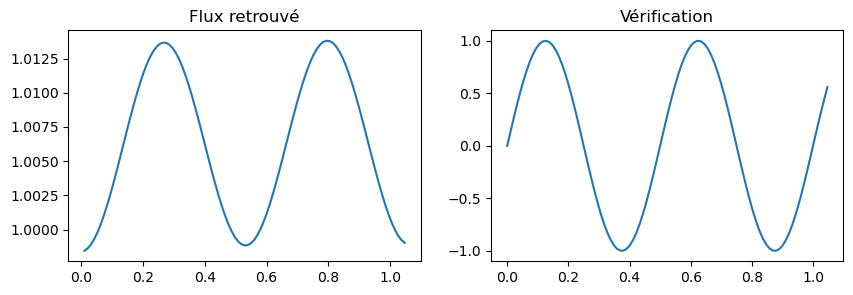

True


In [ ]:
### Résolution problème inverse Gp = d

# Paramètres
n = 40  # Nombre de noeuds
p = 100  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité


def Resolution_i(n, p, L, T, T0, alpha, i, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature qi(t)
    qi = np.zeros((p,1))
    qi[i] = 1

    # Résolution temporelle
    for j in range(1, p):
      if algo == 'Euler':
        U[:, j-1] - np.append(np.zeros(n-1), qi[j])
        U[:, j] = U[:, j-1] - dt * np.linalg.solve(M, K @ U[:, j-1] - np.append(np.zeros(n-1), qi[j]))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, j] = np.linalg.solve(A, B @ U[:, j-1] + dt * np.append(np.zeros(n-1), qi[j]))
    return U



# Algo Crank-Nicholson
U_cn = Resolution(n, p, L, T, T0, alpha, algo='Crank-Nicholson')


### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn[i,:]
  return d


### Construction de G
G = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G[k,i] = Ui[j,i]


### Résolution
d = fd(U_cn)
P = la.pinv(G)@d


### Verification
def f(t) :
  return np.sin(4 * np.pi * t )
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


### Tracé
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(X[1:p], P[1:p])
ax1.set_title('Flux retrouvé')
ax2.plot(X, Y)
ax2.set_title('Vérification')
plt.show()

print(np.allclose(P[1:p], Y[1:p], atol=1e1))


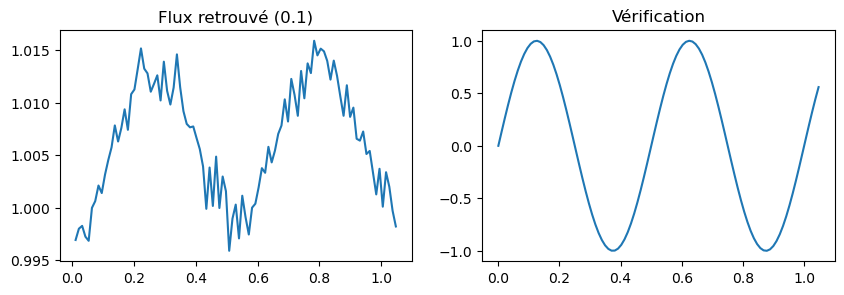

True
1.001595616366565


In [ ]:
### Ajout de bruit

# Paramètres
n = 40  # Nombre de noeuds
p = 100  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité


def Resolution_b(n, p, L, T, T0, alpha, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature q(t)
    def q_func(t):
        return np.sin(4 * np.pi * t / T)

    # Résolution temporelle
    for i in range(1, p):
      if algo == 'Euler':
        U[:, i] = U[:, i-1] - dt * np.linalg.solve(M, K @ U[:, i-1] -np.append(np.zeros(n-1), q_func(i * dt)))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, i] = np.linalg.solve(A, B @ U[:, i-1] + dt * np.append(np.zeros(n-1), q_func(i * dt)))

    bruit = 0.1 * np.random.normal(0, 1, U.shape)
    U_b = U + bruit
    return U_b



# Algo Crank-Nicholson
U_cn_b = Resolution_b(n, p, L, T, T0, alpha, algo='Crank-Nicholson')


### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn_b[i,:]
  return d


### Construction de G
G = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G[k,i] = Ui[j,i]


### Résolution
d = fd(U_cn_b)
P = la.pinv(G)@d


### Verification
def f(t) :
  return np.sin(4 * np.pi * t )
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


### Tracé
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(X[1:p], P[1:p])
ax1.set_title('Flux retrouvé (0.1)')
ax2.plot(X, Y)
ax2.set_title('Vérification')
plt.show()

print(np.allclose(P[1:p], Y[1:p], atol=1e1))
print(la.cond(G))


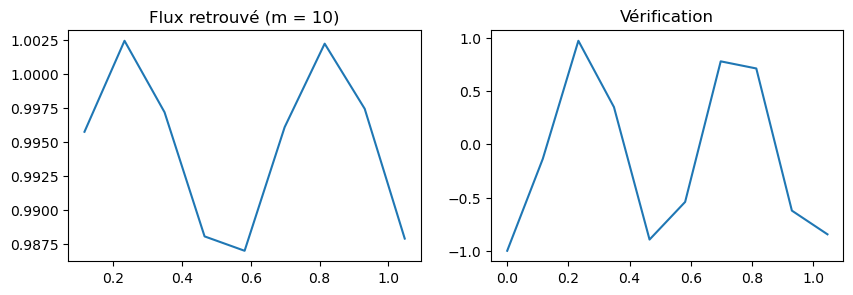

True


In [ ]:
### Modification du pas de temps

# Paramètres
n = 40  # Nombre de noeuds
p = 10  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité


def Resolution(n, p, L, T, T0, alpha, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature q(t)
    def q_func(t):
        return np.sin(4 * np.pi * t / T)

    # Résolution temporelle
    for i in range(1, p):
      if algo == 'Euler':
        U[:, i] = U[:, i-1] - dt * np.linalg.solve(M, K @ U[:, i-1] -np.append(np.zeros(n-1), q_func(i * dt)))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, i] = np.linalg.solve(A, B @ U[:, i-1] + dt * np.append(np.zeros(n-1), q_func(i * dt)))
    return U


def Resolution_i(n, p, L, T, T0, alpha, i, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature qi(t)
    qi = np.zeros((p,1))
    qi[i] = 1

    # Résolution temporelle
    for j in range(1, p):
      if algo == 'Euler':
        U[:, j-1] - np.append(np.zeros(n-1), qi[j])
        U[:, j] = U[:, j-1] - dt * np.linalg.solve(M, K @ U[:, j-1] - np.append(np.zeros(n-1), qi[j]))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, j] = np.linalg.solve(A, B @ U[:, j-1] + dt * np.append(np.zeros(n-1), qi[j]))
    return U


# Algo Crank-Nicholson
U_cn_mod = Resolution(n, p, L, T, T0, alpha, algo='Crank-Nicholson')


### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn_mod[i,:]
  return d


### Construction de G
G_mod = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui_mod = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G_mod[k,i] = Ui_mod[j,i]


### Résolution
d = fd(U_cn_mod)
P = la.pinv(G_mod)@d


### Verification
def f(t) :
  return np.sin(4 * np.pi * t - 1.6)
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


### Tracé
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(X[1:p], P[1:p])
ax1.set_title('Flux retrouvé (m = 10)')
ax2.plot(X, Y)
ax2.set_title('Vérification')
plt.show()

print(np.allclose(P[1:p], Y[1:p], atol=1e1))


Egal G ?  False


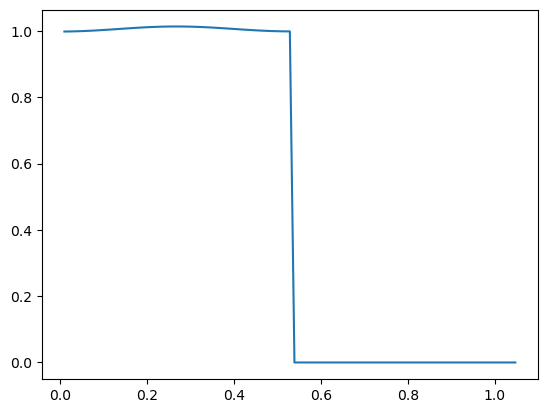

Egal G ?  False


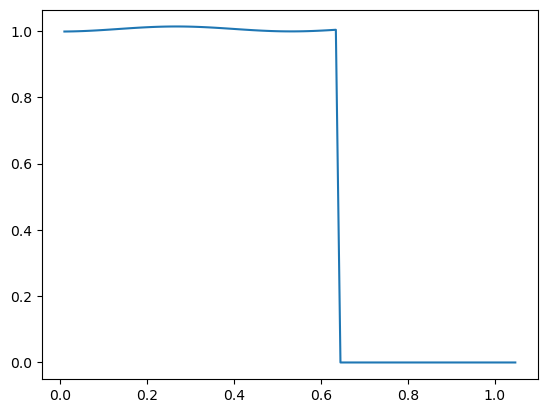

Egal G ?  False


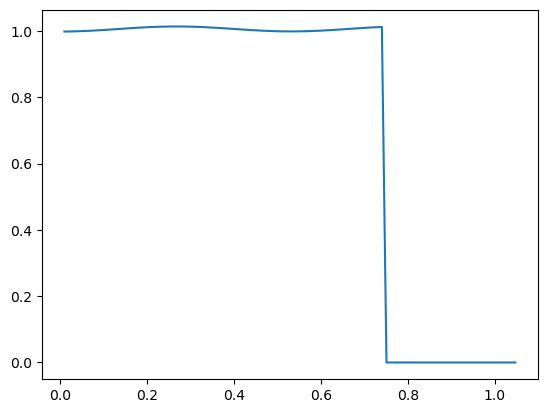

Egal G ?  False


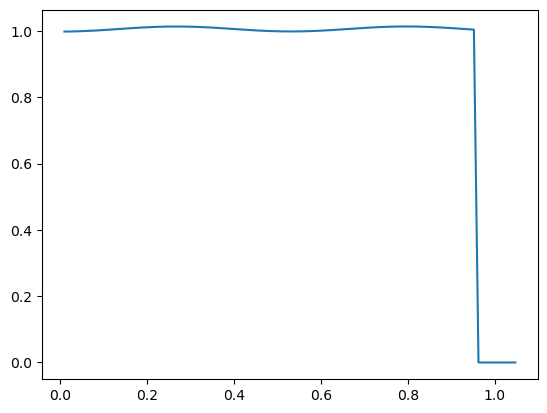

Egal G ?  False


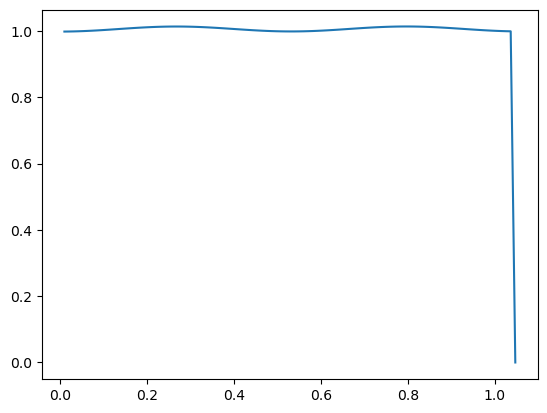

Egal G ?  False


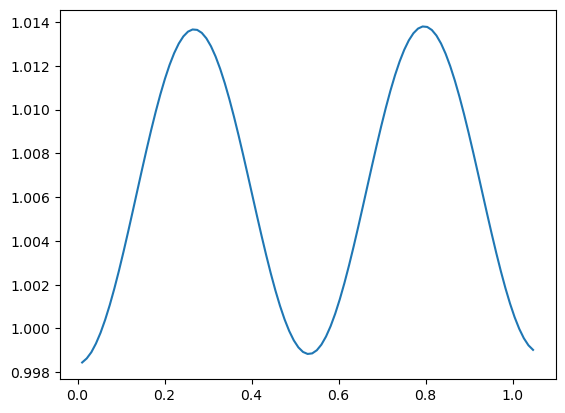

Egal G ?  True


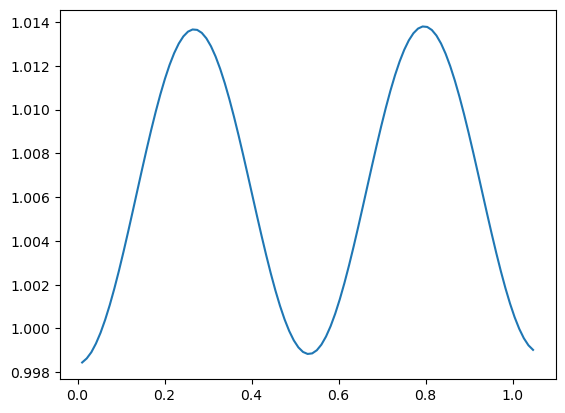

In [ ]:
### SVD


### Résolution problème inverse Gp = d

# Paramètres
n = 40  # Nombre de noeuds
p = 100  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité


def Resolution_i(n, p, L, T, T0, alpha, i, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature qi(t)
    qi = np.zeros((p,1))
    qi[i] = 1

    # Résolution temporelle
    for j in range(1, p):
      if algo == 'Euler':
        U[:, j-1] - np.append(np.zeros(n-1), qi[j])
        U[:, j] = U[:, j-1] - dt * np.linalg.solve(M, K @ U[:, j-1] - np.append(np.zeros(n-1), qi[j]))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, j] = np.linalg.solve(A, B @ U[:, j-1] + dt * np.append(np.zeros(n-1), qi[j]))
    return U



# Algo Crank-Nicholson
U_cn = Resolution(n, p, L, T, T0, alpha, algo='Crank-Nicholson')


### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn[i,:]
  return d


### Construction de G
G = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G[k,i] = Ui[j,i]


### Résolution
d = fd(U_cn)
[U,S,V] = la.svd(G)

for k in [50,60,70,90,98,99,100]: #80,90,95,
    Gk = U[:,:k] @ np.diag(S[:k]) @ V[:k,:]
    Pk = la.pinv(Gk) @ d
    #print('Cond G :',la.cond(Gk))
    print('Egal G ? ',np.allclose(G, Gk, atol = 1))
    plt.plot(X[1:p], Pk[1:p])
    plt.show()



### Verification
def f(t) :
  return np.sin(4 * np.pi * t - 1.6)
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


#print(np.allclose(P[1:p], Y[1:p], atol=1e1))
#print(la.cond(G))

Optimization terminated successfully.
         Current function value: 161.407480
         Iterations: 5
         Function evaluations: 5029


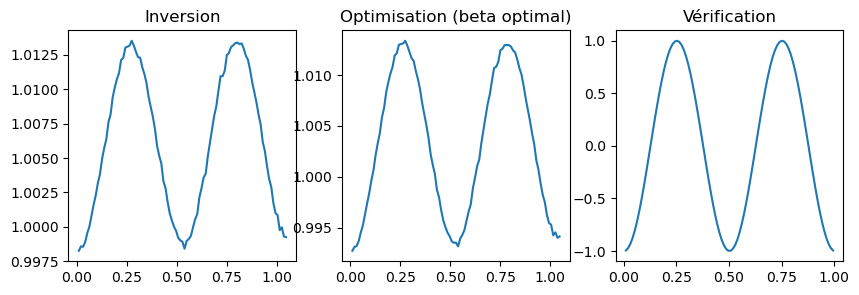

False


In [ ]:
#### Regularisation
import scipy.optimize
from scipy.optimize import minimize

# Paramètres
n = 30  # Nombre de noeuds
p = 100  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité

def Resolution_i(n, p, L, T, T0, alpha, i, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature qi(t)
    qi = np.zeros((p,1))
    qi[i] = 1

    # Résolution temporelle
    for j in range(1, p):
      if algo == 'Euler':
        U[:, j-1] - np.append(np.zeros(n-1), qi[j])
        U[:, j] = U[:, j-1] - dt * np.linalg.solve(M, K @ U[:, j-1] - np.append(np.zeros(n-1), qi[j]))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, j] = np.linalg.solve(A, B @ U[:, j-1] + dt * np.append(np.zeros(n-1), qi[j]))
    return U


def Resolution_b(n, p, L, T, T0, alpha, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature q(t)
    def q_func(t):
        return np.sin(4 * np.pi * t / T)

    # Résolution temporelle
    for i in range(1, p):
      if algo == 'Euler':
        U[:, i] = U[:, i-1] - dt * np.linalg.solve(M, K @ U[:, i-1] -np.append(np.zeros(n-1), q_func(i * dt)))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, i] = np.linalg.solve(A, B @ U[:, i-1] + dt * np.append(np.zeros(n-1), q_func(i * dt)))

    bruit = 0.01 * np.random.normal(0, 1, U.shape)
    U_b = U + bruit
    return U_b




# Algo Crank-Nicholson
U_cn_b = Resolution_b(n, p, L, T, T0, alpha, algo='Crank-Nicholson')


### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn_b[i,:]
  return d


### Construction de G
G = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G[k,i] = Ui[j,i]


### Verification
def f(t) :
  return np.sin(4 * np.pi * t -1.6)
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


### Résolution
d = fd(U_cn_b)
P = la.pinv(G)@d


def Sbeta(p):
    return la.norm(G@p - d, 2) + beta * la.norm(p - Y, 2)

beta = 12
x0 = 0.5 * np.zeros(p)
lw = [-1] * 100
up = [2] * 100
bounds=list(zip(lw, up))
#res = minimize(Sbeta, x0, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
res = minimize(Sbeta, x0, method='Powell',options={'disp': True})
#scipy.optimize.dual_annealing(Sbeta, bounds, maxiter=1000, minimizer_kwargs=None, initial_temp=5230.0, restart_temp_ratio=2e-05, visit=2.62, accept=-5.0, maxfun=10000000.0, seed=None, no_local_search=False, callback=None, x0=None)

#print(np.shape(res.x))

### Tracé
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ax1.plot(X[1:p], P[1:p])
ax1.set_title('Inversion')
ax3.plot(X[1:p-5], Y[1:p-5])
ax3.set_title('Vérification')
ax2.plot(X[1:p], res.x[1:p])
ax2.set_title('Optimisation (beta optimal)')
plt.show()

print(np.allclose(P[1:p], res.x[1:p], atol=1e-18))
#print(la.cond(G))


In [ ]:
G = [[10,2,3],[4,5,6],[7,8,9]]
d = [1,4,8]

d1 = la.solve(G,d)
d2 = la.inv(G) @ d

print(d1)
print(d2)

def f(p):
    return la.norm(G@p - d,2)

x0 = [1,0,0]
d3 = minimize(f, x0, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
print(d3)


[ 0.11111111  3.77777778 -2.55555556]
[ 0.11111111  3.77777778 -2.55555556]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 265
         Function evaluations: 480
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.2849465227625274e-09
             x: [ 1.111e-01  3.778e+00 -2.556e+00]
           nit: 265
          nfev: 480
 final_simplex: (array([[ 1.111e-01,  3.778e+00, -2.556e+00],
                       [ 1.111e-01,  3.778e+00, -2.556e+00],
                       [ 1.111e-01,  3.778e+00, -2.556e+00],
                       [ 1.111e-01,  3.778e+00, -2.556e+00]]), array([ 1.285e-09,  2.044e-09,  2.358e-09,  2.489e-09]))


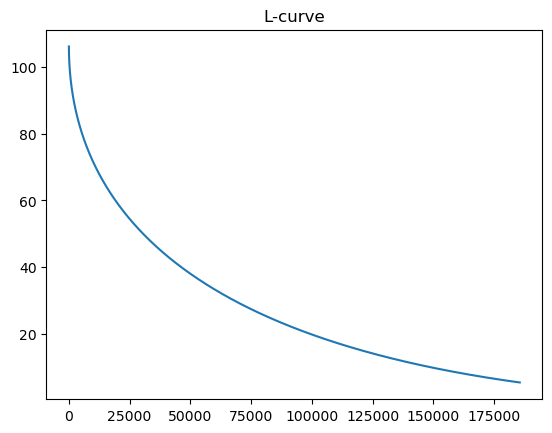

Beta optimal : 12


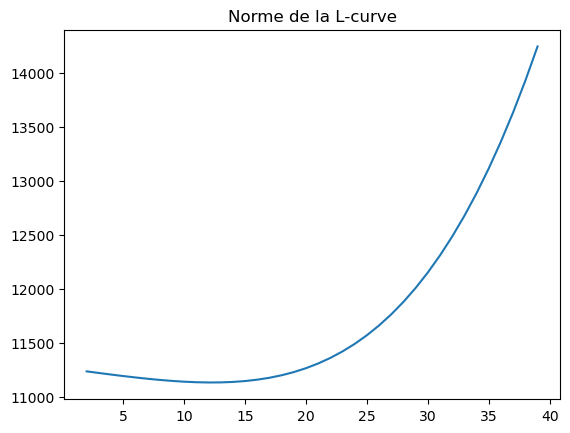

Optimization terminated successfully.
         Current function value: 225.036843
         Iterations: 5
         Function evaluations: 4856


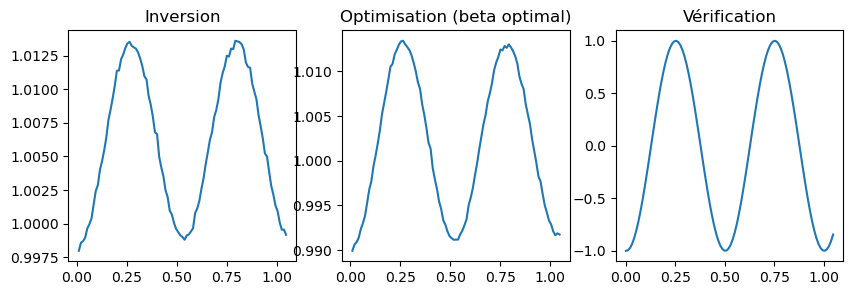

In [ ]:
#### L-curve
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import minimize

# Paramètres
n = 30  # Nombre de noeuds
p = 100  # Nombre de pas de temps
L = 1.0  # Longeur totale
T = 1.0  # Temps total
T0 = 10.0  # Température initiale
alpha = 0.1  # Coefficient de diffusivité

def Resolution_i(n, p, L, T, T0, alpha, i, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature qi(t)
    qi = np.zeros((p,1))
    qi[i] = 1

    # Résolution temporelle
    for j in range(1, p):
      if algo == 'Euler':
        U[:, j-1] - np.append(np.zeros(n-1), qi[j])
        U[:, j] = U[:, j-1] - dt * np.linalg.solve(M, K @ U[:, j-1] - np.append(np.zeros(n-1), qi[j]))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, j] = np.linalg.solve(A, B @ U[:, j-1] + dt * np.append(np.zeros(n-1), qi[j]))
    return U


def Resolution_b(n, p, L, T, T0, alpha, algo):
    h = L / n  # Espace
    dt = T / p  # Temps

    # Matrices K et M
    K = (2 * np.eye(n) - (np.tri(n, n, -1) - np.tri(n, n, -2)) - (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    K[0, 0] = 1
    K[-1, -1] = 1
    K = (alpha / h) * K
    M = (4 * np.eye(n) + (np.tri(n, n, -1) - np.tri(n, n, -2)) + (np.tri(n, n, -1).T - np.tri(n, n, -2).T))
    M[0, 0] = 2
    M[-1, -1] = 2
    M = (h / 6) * M

    # Initialisation
    U = np.zeros((n, p))
    U[:, 0] = T0

    # Flux de temperature q(t)
    def q_func(t):
        return np.sin(4 * np.pi * t / T)

    # Résolution temporelle
    for i in range(1, p):
      if algo == 'Euler':
        U[:, i] = U[:, i-1] - dt * np.linalg.solve(M, K @ U[:, i-1] -np.append(np.zeros(n-1), q_func(i * dt)))
      elif algo == 'Crank-Nicholson':
        A = M + dt / 2 * K
        B = M - dt / 2 * K
        U[:, i] = np.linalg.solve(A, B @ U[:, i-1] + dt * np.append(np.zeros(n-1), q_func(i * dt)))

    bruit = 0.01 * np.random.normal(0, 1, U.shape)
    U_b = U + bruit
    return U_b




# Algo Crank-Nicholson
U_cn_b = Resolution_b(n, p, L, T, T0, alpha, algo='Crank-Nicholson')

### Creation du vecteur d
def fd(U):
  d = np.zeros((n-1)*p)
  for i in range(n-1):
    d[p*i:p*(i+1)] = U_cn_b[i,:]
  return d


### Construction de G
G = np.zeros(((n-1)*p,p))
for i in range(p):
  Ui = Resolution_i(n, p, L, T, T0, alpha, i, 'Crank-Nicholson')
  for j in range(n):
    k = p*(j-1) + i
    G[k,i] = Ui[j,i]

[U,S,V] = la.svd(G)


### Verification
def f(t) :
  return np.sin(4 * np.pi * t -1.6)
X = np.linspace(0, np.pi/3, p)
Y = [ f(x) for x in X ]


### Résolution
d = fd(U_cn_b)

def fD(beta):
    D = 0
    for lamb in S :
        if lamb != 0:
            D += beta**2 * (lamb*Y[i] - d[i])**2 / (lamb**2 + beta)**2
        else :
            D += d[i]**2
    return D

def fOM(beta):
    OM = 0
    for lamb in S :
        OM += lamb**2 * (lamb*Y[i] - d[i])**2 / (lamb**2 + beta)**2
    return OM


beta_max = 10000
D = np.zeros(beta_max - 1)
OM = np.zeros(beta_max - 1)

for beta in range(beta_max-1):
    D[beta] = fD(beta)
    OM[beta] = fOM(beta)
    #if np.isclose(D[beta],0,atol=1e-2) :
        #print('beta :',beta)

Dplot = D[2:10000]
OMplot = OM[2: 10000]
plt.plot(Dplot,OMplot)
plt.title('L-curve')
plt.show()

#print(Dplot)
#print(OMplot)

Norms = Dplot**2 + OMplot**2
beta_opt = np.argmin(Norms)
print('Beta optimal :',beta_opt)

x = np.arange(len(Dplot))
plt.plot(x[2:40],Norms[2:40])
plt.title('Norme de la L-curve')
plt.show()







P = la.pinv(G)@d


def Sbeta(p):
    return la.norm(G@p - d, 2) + beta * la.norm(p - Y, 2)

beta = beta_opt + 5
x0 = 0.5 * np.zeros(p)
lw = [-1] * 100
up = [2] * 100
bounds=list(zip(lw, up))
#res = minimize(Sbeta, x0, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
res = minimize(Sbeta, x0, method='Powell',options={'disp': True})
#scipy.optimize.dual_annealing(Sbeta, bounds, maxiter=1000, minimizer_kwargs=None, initial_temp=5230.0, restart_temp_ratio=2e-05, visit=2.62, accept=-5.0, maxfun=10000000.0, seed=None, no_local_search=False, callback=None, x0=None)

### Tracé
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ax1.plot(X[1:p], P[1:p])
ax1.set_title('Inversion')
ax3.plot(X, Y)
ax3.set_title('Vérification')
ax2.plot(X[1:p], res.x[1:p])
ax2.set_title('Optimisation (beta optimal)')
plt.show()
